In [1]:
import json
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import importlib
import sys
sys.path.insert(0, '../utils')
import data_utils
import visualization
import evaluation

# importlib.reload(visualization)

sys.path.insert(0, '../models')
import log_reg_word_embeddings

In [3]:
np.random.seed(42)

In [4]:
df_train = data_utils.load_data_set('../data/train/train.csv')
df_train_x = df_train[['head.word', 'tail.word', 'sentence']]
df_train_y = df_train['relation']

In [5]:
df_test = data_utils.load_data_set('../data/test/test.csv')
df_test_x = df_test[['head.word', 'tail.word', 'sentence']]
df_test_y = df_test['relation']

In [6]:
df_full = df_train.append(df_test)

In [8]:
df_full['head.word']

0                      Syracuse
1                      Syracuse
2                      Syracuse
3                        Turkey
4                        Turkey
5                        Queens
6                        Queens
7                        Queens
8                        Queens
9                        Queens
10                       Queens
11                       Queens
12                       Queens
13                       Queens
14                       Queens
15                      Hokusai
16        Chandrika Kumaratunga
17        Chandrika Kumaratunga
18        Chandrika Kumaratunga
19                   California
20              Pietro Annigoni
21             Barbara Stanwyck
22                  Jorge Amado
23                Lauren Conrad
24                Lauren Conrad
25               Roland Barthes
26               North Carolina
27                        Amway
28           Simone de Beauvoir
29           Simone de Beauvoir
                  ...          
172418  

In [9]:
with open('../data/classes.json') as f:
    classes_json = json.load(f)
classes = np.asarray(list(classes_json.keys()))

In [10]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(df_train_y), df_train_y)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1932.414814814815,
 1: 19.302700702922678,
 2: 53.02357723577236,
 3: 26.839094650205762,
 4: 8695.866666666667,
 5: 2.370737913486005,
 6: 966.2074074074075,
 7: 966.2074074074075,
 8: 2.387007045475341,
 9: 4347.933333333333,
 10: 2.387007045475341,
 11: 1.9578670869451011,
 12: 0.2606635591992526,
 13: 1.875119496855346,
 14: 445.94188034188033,
 15: 158.10666666666665,
 16: 21.794152046783626,
 17: 724.6555555555556,
 18: 7.180732177263969,
 19: 202.22945736434107,
 20: 27.960986066452303,
 21: 117.51171171171171,
 22: 1.7872503682389613,
 23: 1.9530301328841475,
 24: 4.291076568796776,
 25: 86.09768976897689,
 26: 724.6555555555556,
 27: 59.15555555555556,
 28: 4347.933333333333,
 29: 0.04510596727830729}

In [11]:
MAX_WORDS = 150000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

MAX_ENTITY_WORDS = 40000
MAX_ENTITY_LENGTH = 4
ENTITY_EMBEDDING_DIM = 100

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_full['sentence'])
word_index = tokenizer.word_index

In [16]:
entity_tokenizer = Tokenizer(num_words=MAX_ENTITY_WORDS)
entity_tokenizer.fit_on_texts(df_full['head.word'].append(df_full['tail.word']))
entity_word_index = entity_tokenizer.word_index

In [17]:
len(entity_word_index)

40124

In [18]:
# load GloVe 100 dim word embeddings
embeddings_index = {}
f = open('../data/external/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [19]:
# use word_index and embeddings_index to construct embedding_matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape

(147420, 100)

In [21]:
# use entity_word_index and embeddings_index to construct entity_embedding_matrix
entity_embedding_matrix = np.zeros((len(entity_word_index) + 1, ENTITY_EMBEDDING_DIM))
for word, i in entity_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        entity_embedding_matrix[i] = embedding_vector

In [22]:
entity_embedding_matrix.shape

(40125, 100)

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, concatenate


#sentence

sentence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
sentence_embedding = Embedding(len(word_index) + 1,
                               EMBEDDING_DIM,
                               weights=[embedding_matrix],
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)(sentence_input)
lstm = LSTM(100)(sentence_embedding)
dropout1 = Dropout(0.2)(lstm)
hidden1 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden1)
output = Dense(len(classes), activation='softmax')(dropout2)

model = Model(inputs=[sentence_input],
              outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          14742000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1950      
Total para

In [25]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')

In [26]:
train_sequences = tokenizer.texts_to_sequences(df_train_x['sentence'])

In [27]:
padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [28]:
padded_train_head = pad_sequences(entity_tokenizer.texts_to_sequences(df_train_x['head.word']), maxlen=MAX_ENTITY_LENGTH)
padded_train_tail = pad_sequences(entity_tokenizer.texts_to_sequences(df_train_x['tail.word']), maxlen=MAX_ENTITY_LENGTH)

In [29]:
# from tensorflow.keras.utils import to_categorical
# labels = to_categorical(classes)

from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder()
label_encoder.fit(classes.reshape(-1, 1))

labels = label_encoder.transform(df_train_y.values.reshape(-1, 1)).todense()

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [30]:
print('Shape of data tensor:', padded_train_sequences.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (521752, 100)
Shape of label tensor: (521752, 30)


In [51]:
history = model.fit(
    [padded_train_sequences],
    np.asarray(labels),
    epochs=3,
    batch_size=200,
    class_weight=class_weights_dict,
    validation_split=0.2
)

Train on 417401 samples, validate on 104351 samples
Epoch 1/3
417401/417401 [==============================] - 403s 964us/step - loss: 2.2659 - acc: 0.0805 - val_loss: 2.8090 - val_acc: 0.0384
Epoch 2/3
417401/417401 [==============================] - 397s 951us/step - loss: 1.6095 - acc: 0.1180 - val_loss: 2.6023 - val_acc: 0.0866
Epoch 3/3
417401/417401 [==============================] - 407s 975us/step - loss: 1.3472 - acc: 0.1460 - val_loss: 2.7566 - val_acc: 0.0658


In [52]:
model.save('../trained_models/lstm_3_class_weights.h5')

In [35]:
test_sequences = tokenizer.texts_to_sequences(df_test_x['sentence'])
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [31]:
padded_test_head = pad_sequences(entity_tokenizer.texts_to_sequences(df_test_x['head.word']), maxlen=MAX_ENTITY_LENGTH)
padded_test_tail = pad_sequences(entity_tokenizer.texts_to_sequences(df_test_x['tail.word']), maxlen=MAX_ENTITY_LENGTH)

In [36]:
test_labels = label_encoder.transform(df_test_y.values.reshape(-1, 1)).todense()

In [37]:
scores = model.evaluate([padded_test_sequences], test_labels)

 20320/172442 [==>...........................] - ETA: 1:05

KeyboardInterrupt: 

In [33]:
scores

[0.2966721483257834, 0.9060031778800988]

In [53]:
predictions = model.predict([padded_test_sequences])

In [54]:
predicted_labels = label_encoder.inverse_transform(predictions).ravel()

In [55]:
from collections import Counter
Counter(predicted_labels)

gold_labels = df_test_y

Counter(gold_labels)

Counter({'/people/deceased_person/place_of_death': 11821,
         '/business/company/place_founded': 13267,
         '/people/person/place_of_birth': 10486,
         '/location/country/capital': 9487,
         '/people/person/nationality': 10767,
         '/business/company/major_shareholders': 2210,
         '/people/person/ethnicity': 4101,
         '/location/neighborhood/neighborhood_of': 7146,
         '/people/person/place_lived': 12851,
         '/location/location/contains': 11215,
         '/people/person/children': 28439,
         '/location/country/administrative_divisions': 10539,
         '/business/company/founders': 7049,
         '/location/us_county/county_seat': 2760,
         '/location/administrative_division/country': 5447,
         '/people/person/religion': 1210,
         '/people/ethnicity/geographic_distribution': 2876,
         '/business/person/company': 5554,
         '/sports/sports_team/location': 6406,
         'NA': 5980,
         '/people/deceased_pers

Counter({'/people/person/place_of_birth': 162,
         '/people/person/nationality': 723,
         '/people/person/place_lived': 450,
         '/location/location/contains': 2793,
         '/sports/sports_team/location': 10,
         '/business/person/company': 302,
         '/location/country/capital': 553,
         '/business/company/founders': 95,
         '/film/film/featured_film_locations': 2,
         '/location/administrative_division/country': 424,
         '/location/us_county/county_seat': 23,
         '/people/deceased_person/place_of_death': 68,
         '/business/company/place_founded': 20,
         '/location/neighborhood/neighborhood_of': 68,
         '/people/person/children': 30,
         '/film/film_location/featured_in_films': 2,
         '/people/ethnicity/geographic_distribution': 136,
         '/location/country/administrative_divisions': 424,
         '/location/us_state/capital': 39,
         '/business/company_advisor/companies_advised': 8,
         '/time/e

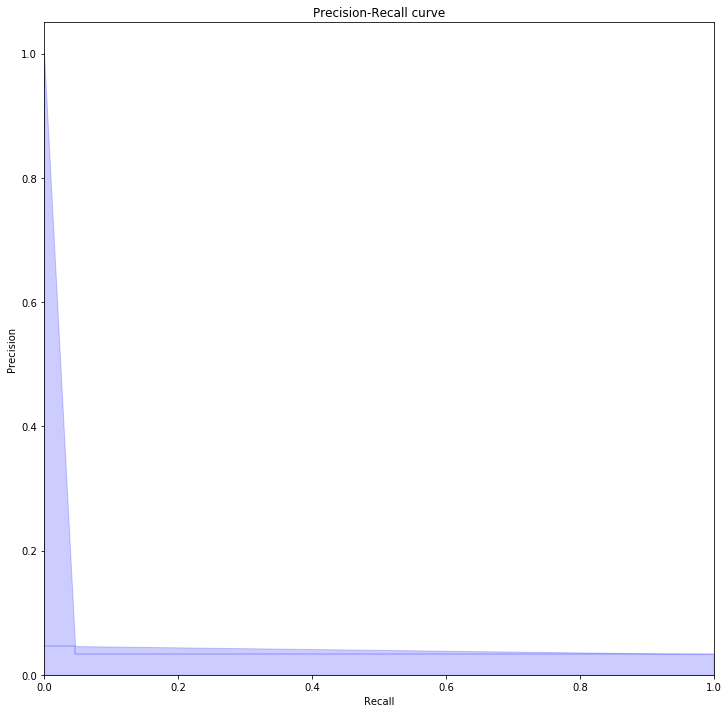

<module 'matplotlib.pyplot' from '/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [56]:
# Precision-Recall Curve
precision, recall, threshold = evaluation.compute_precision_recall_curve(
    y_true=df_test_y.values.reshape(-1, 1),
    y_pred=predicted_labels.reshape(-1, 1),
    classes=classes.reshape(-1, 1)
)

plt.rcParams["figure.figsize"] = (12, 12)
visualization.plot_precision_recall_curve(precision, recall)

In [57]:
score = evaluation.compute_score(predicted_labels, gold_labels, labels=classes)

/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/tony/source/relation-extraction/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [58]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(
    y_true=gold_labels,
    y_pred=predicted_labels,
    labels=classes
)
cnf_matrix

array([[    0,     2,     0,     0,     0,     6,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,    78,     9,     4,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     3,     0,     0,     0,     0,
            0,     0,     0],
       [    0,    10,    33,     0,     0,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     1,     1,    15,     0,     0,     0,     0,     0,
            0,     0,     0,     2,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     2,     0,

In [59]:
def get_results(name, config, score, cnf_matrix, history):
    return {
        'name': name,
        'config': config,
        'score': score,
        'confusion_matrix': cnf_matrix.tolist(),
        'history': history.history,
        'params': history.params
    }

import datetime
import time

def persist_results(results):    
    timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
    with open('../results/{}-{}.json'.format(timestamp, results['name']), 'w') as f:
        json.dump(results, f)


config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'MAX_ENTITY_WORDS': MAX_ENTITY_WORDS,
    'MAX_ENTITY_LENGTH': MAX_ENTITY_LENGTH,
    'ENTITY_EMBEDDING_DIM': ENTITY_EMBEDDING_DIM
}


results = get_results('lstm', config, score, cnf_matrix, history)
results
persist_results(results)

{'name': 'lstm',
 'config': {'MAX_WORDS': 150000,
  'MAX_SEQUENCE_LENGTH': 100,
  'EMBEDDING_DIM': 100,
  'MAX_ENTITY_WORDS': 40000,
  'MAX_ENTITY_LENGTH': 4,
  'ENTITY_EMBEDDING_DIM': 100},
 'score': {'accuracy': 0.04627063012491157,
  'precision': 0.9601876020600146,
  'recall': 0.04627063012491157,
  'f1': 0.06854419643430627},
 'confusion_matrix': [[0,
   2,
   0,
   0,
   0,
   6,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   78,
   9,
   4,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   3,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   10,
   33,
   0,
   0,
   3,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   1,
   1,
   15,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   1,
   0,
   0,
   0

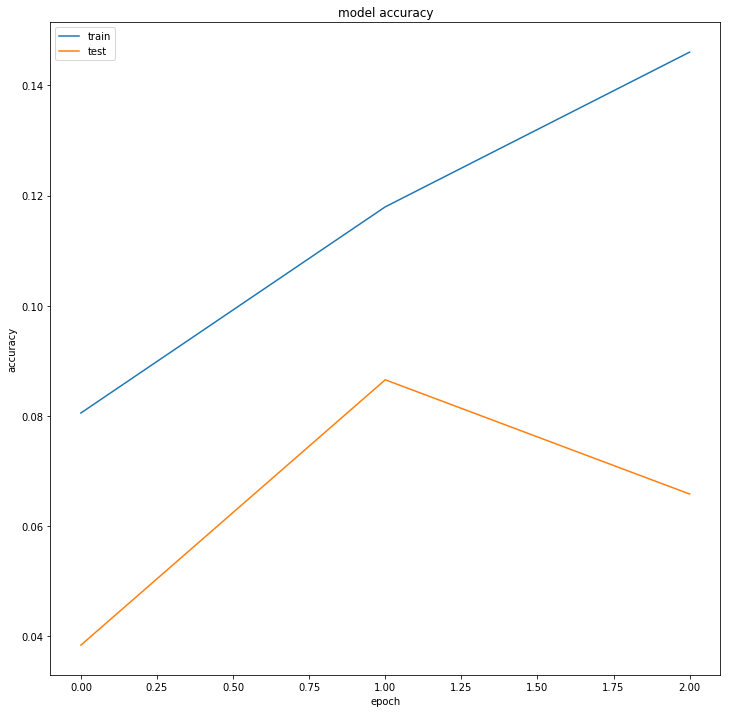

In [60]:
def visualize_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    return plt

visualize_history(history).show()

In [61]:
history.params

{'batch_size': 200,
 'epochs': 3,
 'steps': None,
 'samples': 417401,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
 'validation_steps': None}

Confusion matrix, without normalization
[[    0     2     0     0     0     6     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [    0    78     9     4     0     0     0     0     0     0     0     0
      0     1     0     0     0     0     0     0     0     0     3     0
      0     0     0     0     0     0]
 [    0    10    33     0     0     3     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [    0     1     1    15     0     0     0     0     0     0     0     0
      2     1     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [    0     2     0     0     0     6     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [    0   123    62    16

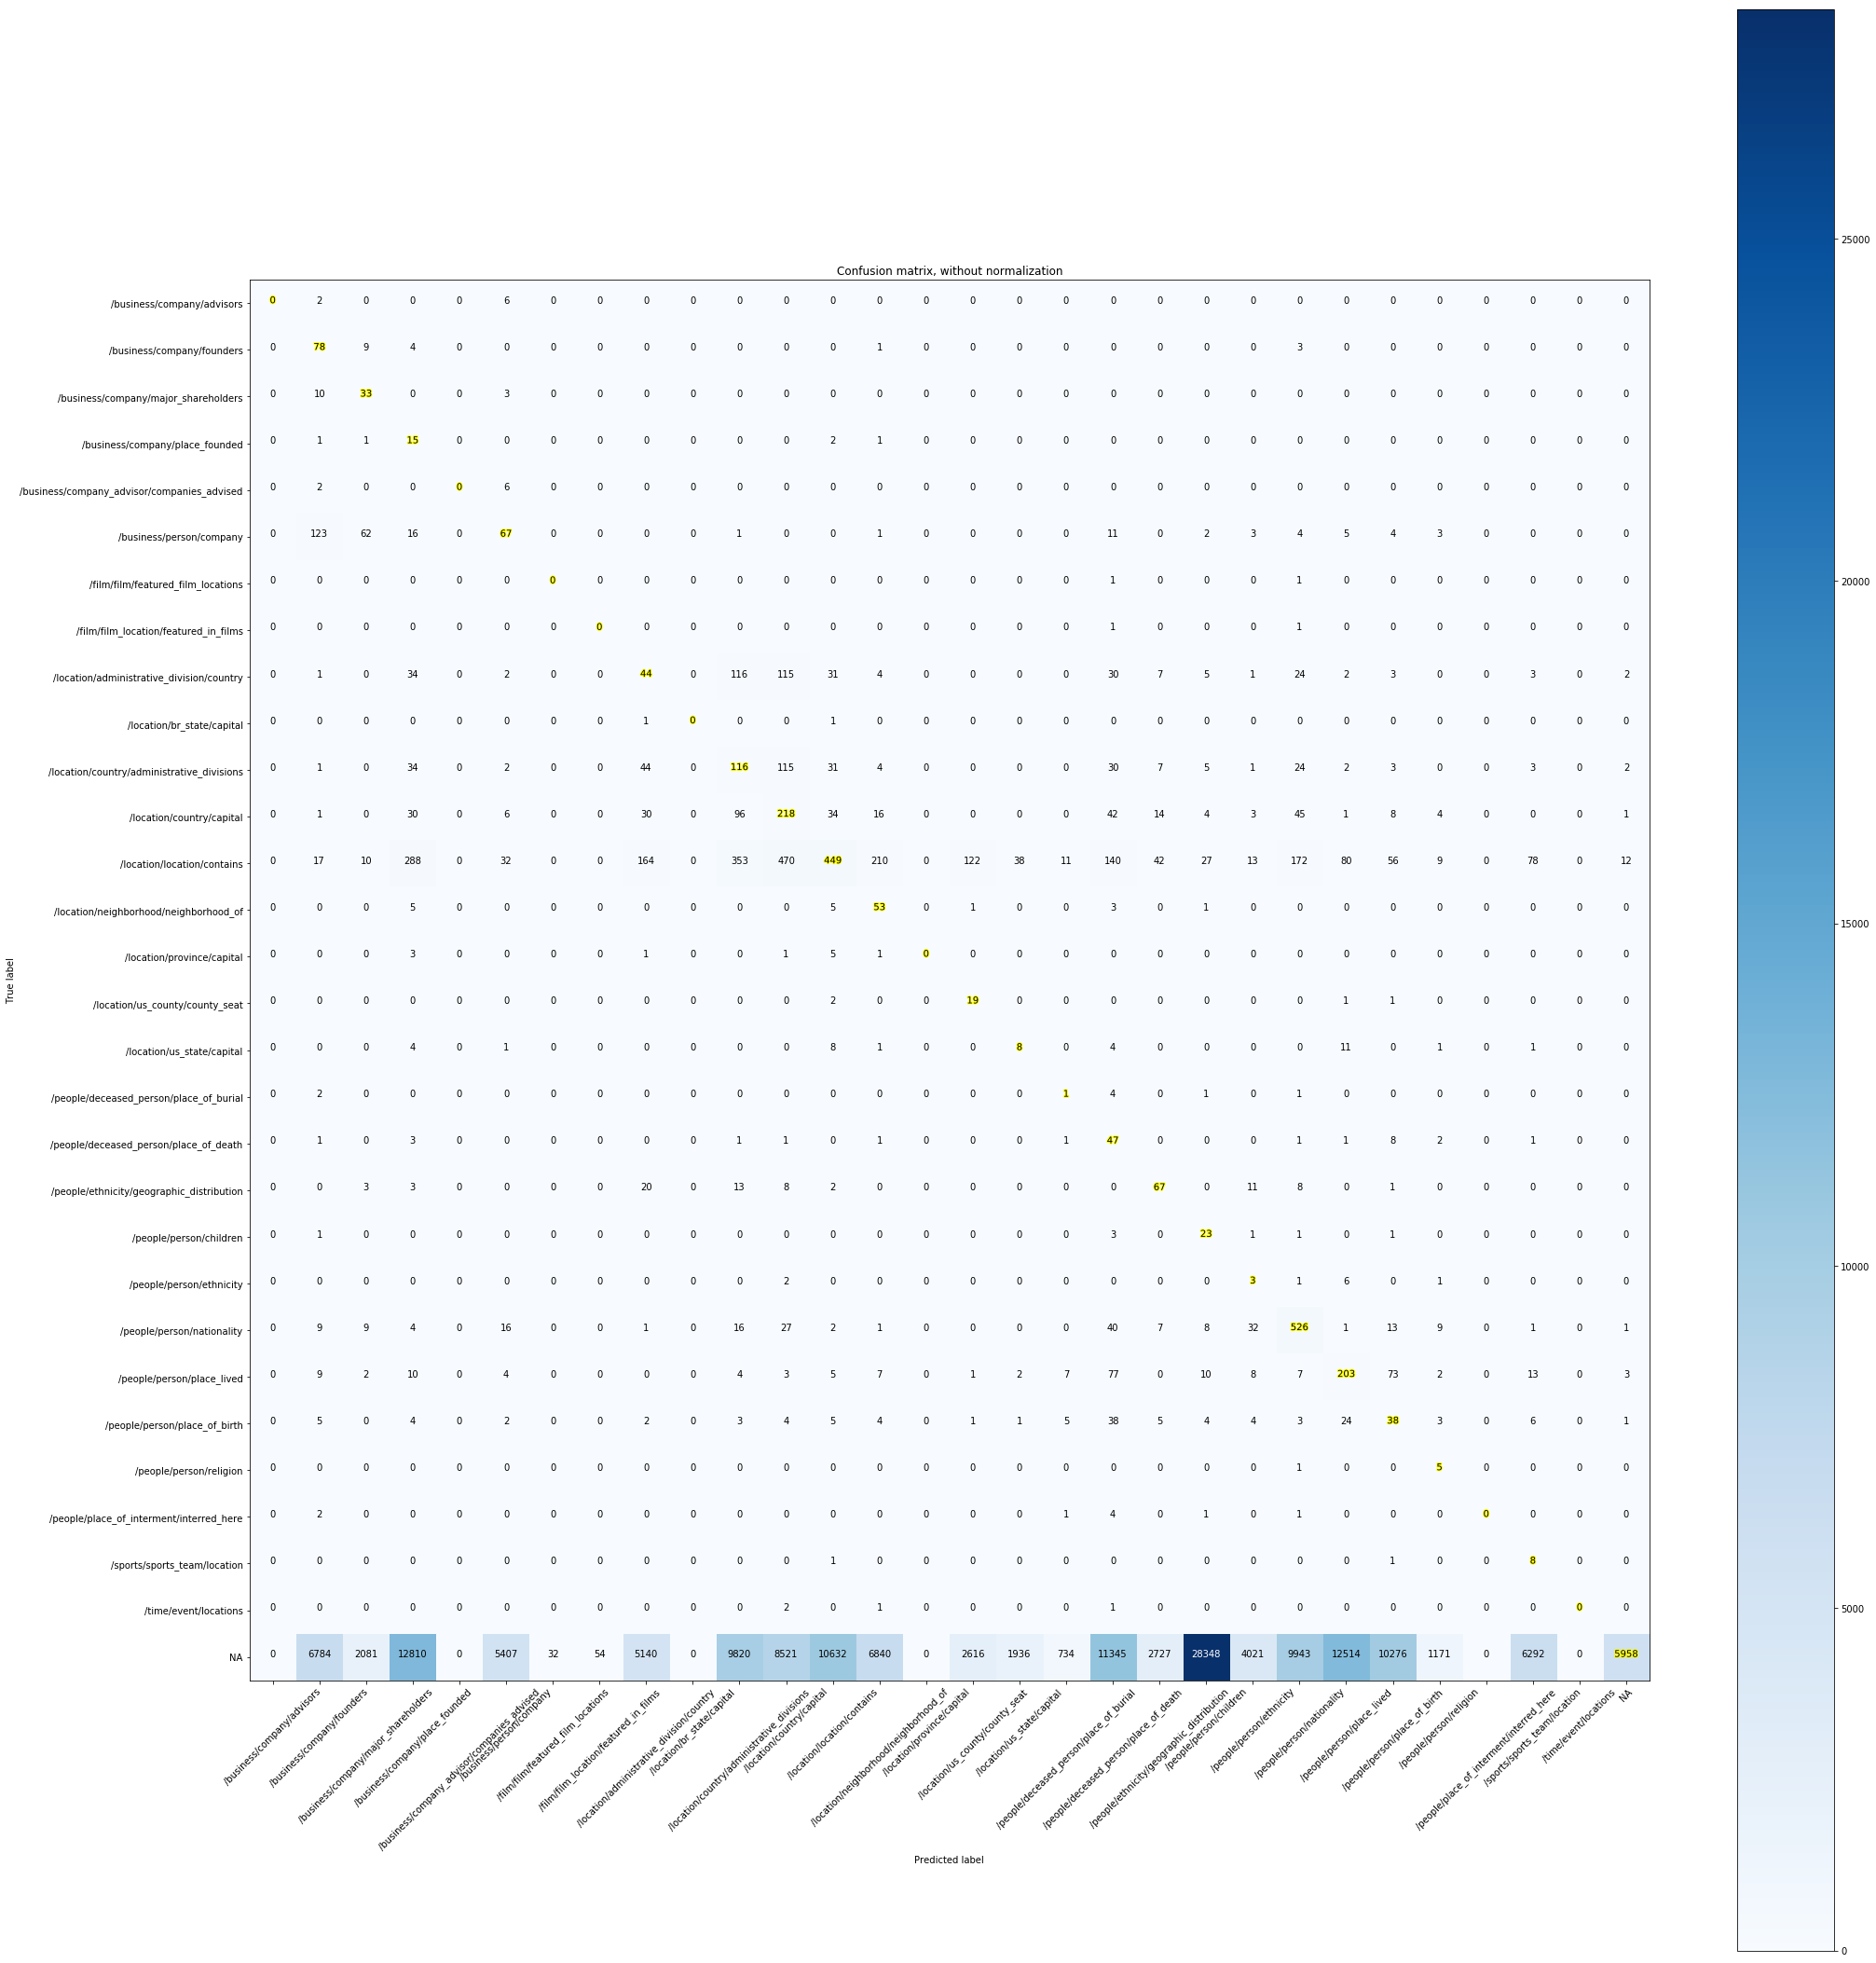

Normalized confusion matrix
[[0.0e+00 2.5e-01 0.0e+00 0.0e+00 0.0e+00 7.5e-01 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 8.2e-01 9.5e-02 4.2e-02 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.1e-02 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 3.2e-02 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 2.2e-01 7.2e-01 0.0e+00 0.0e+00 6.5e-02 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 5.0e-02 5.0e-02 7.5e-01 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 1.0e-01 5.0e-02 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
  0

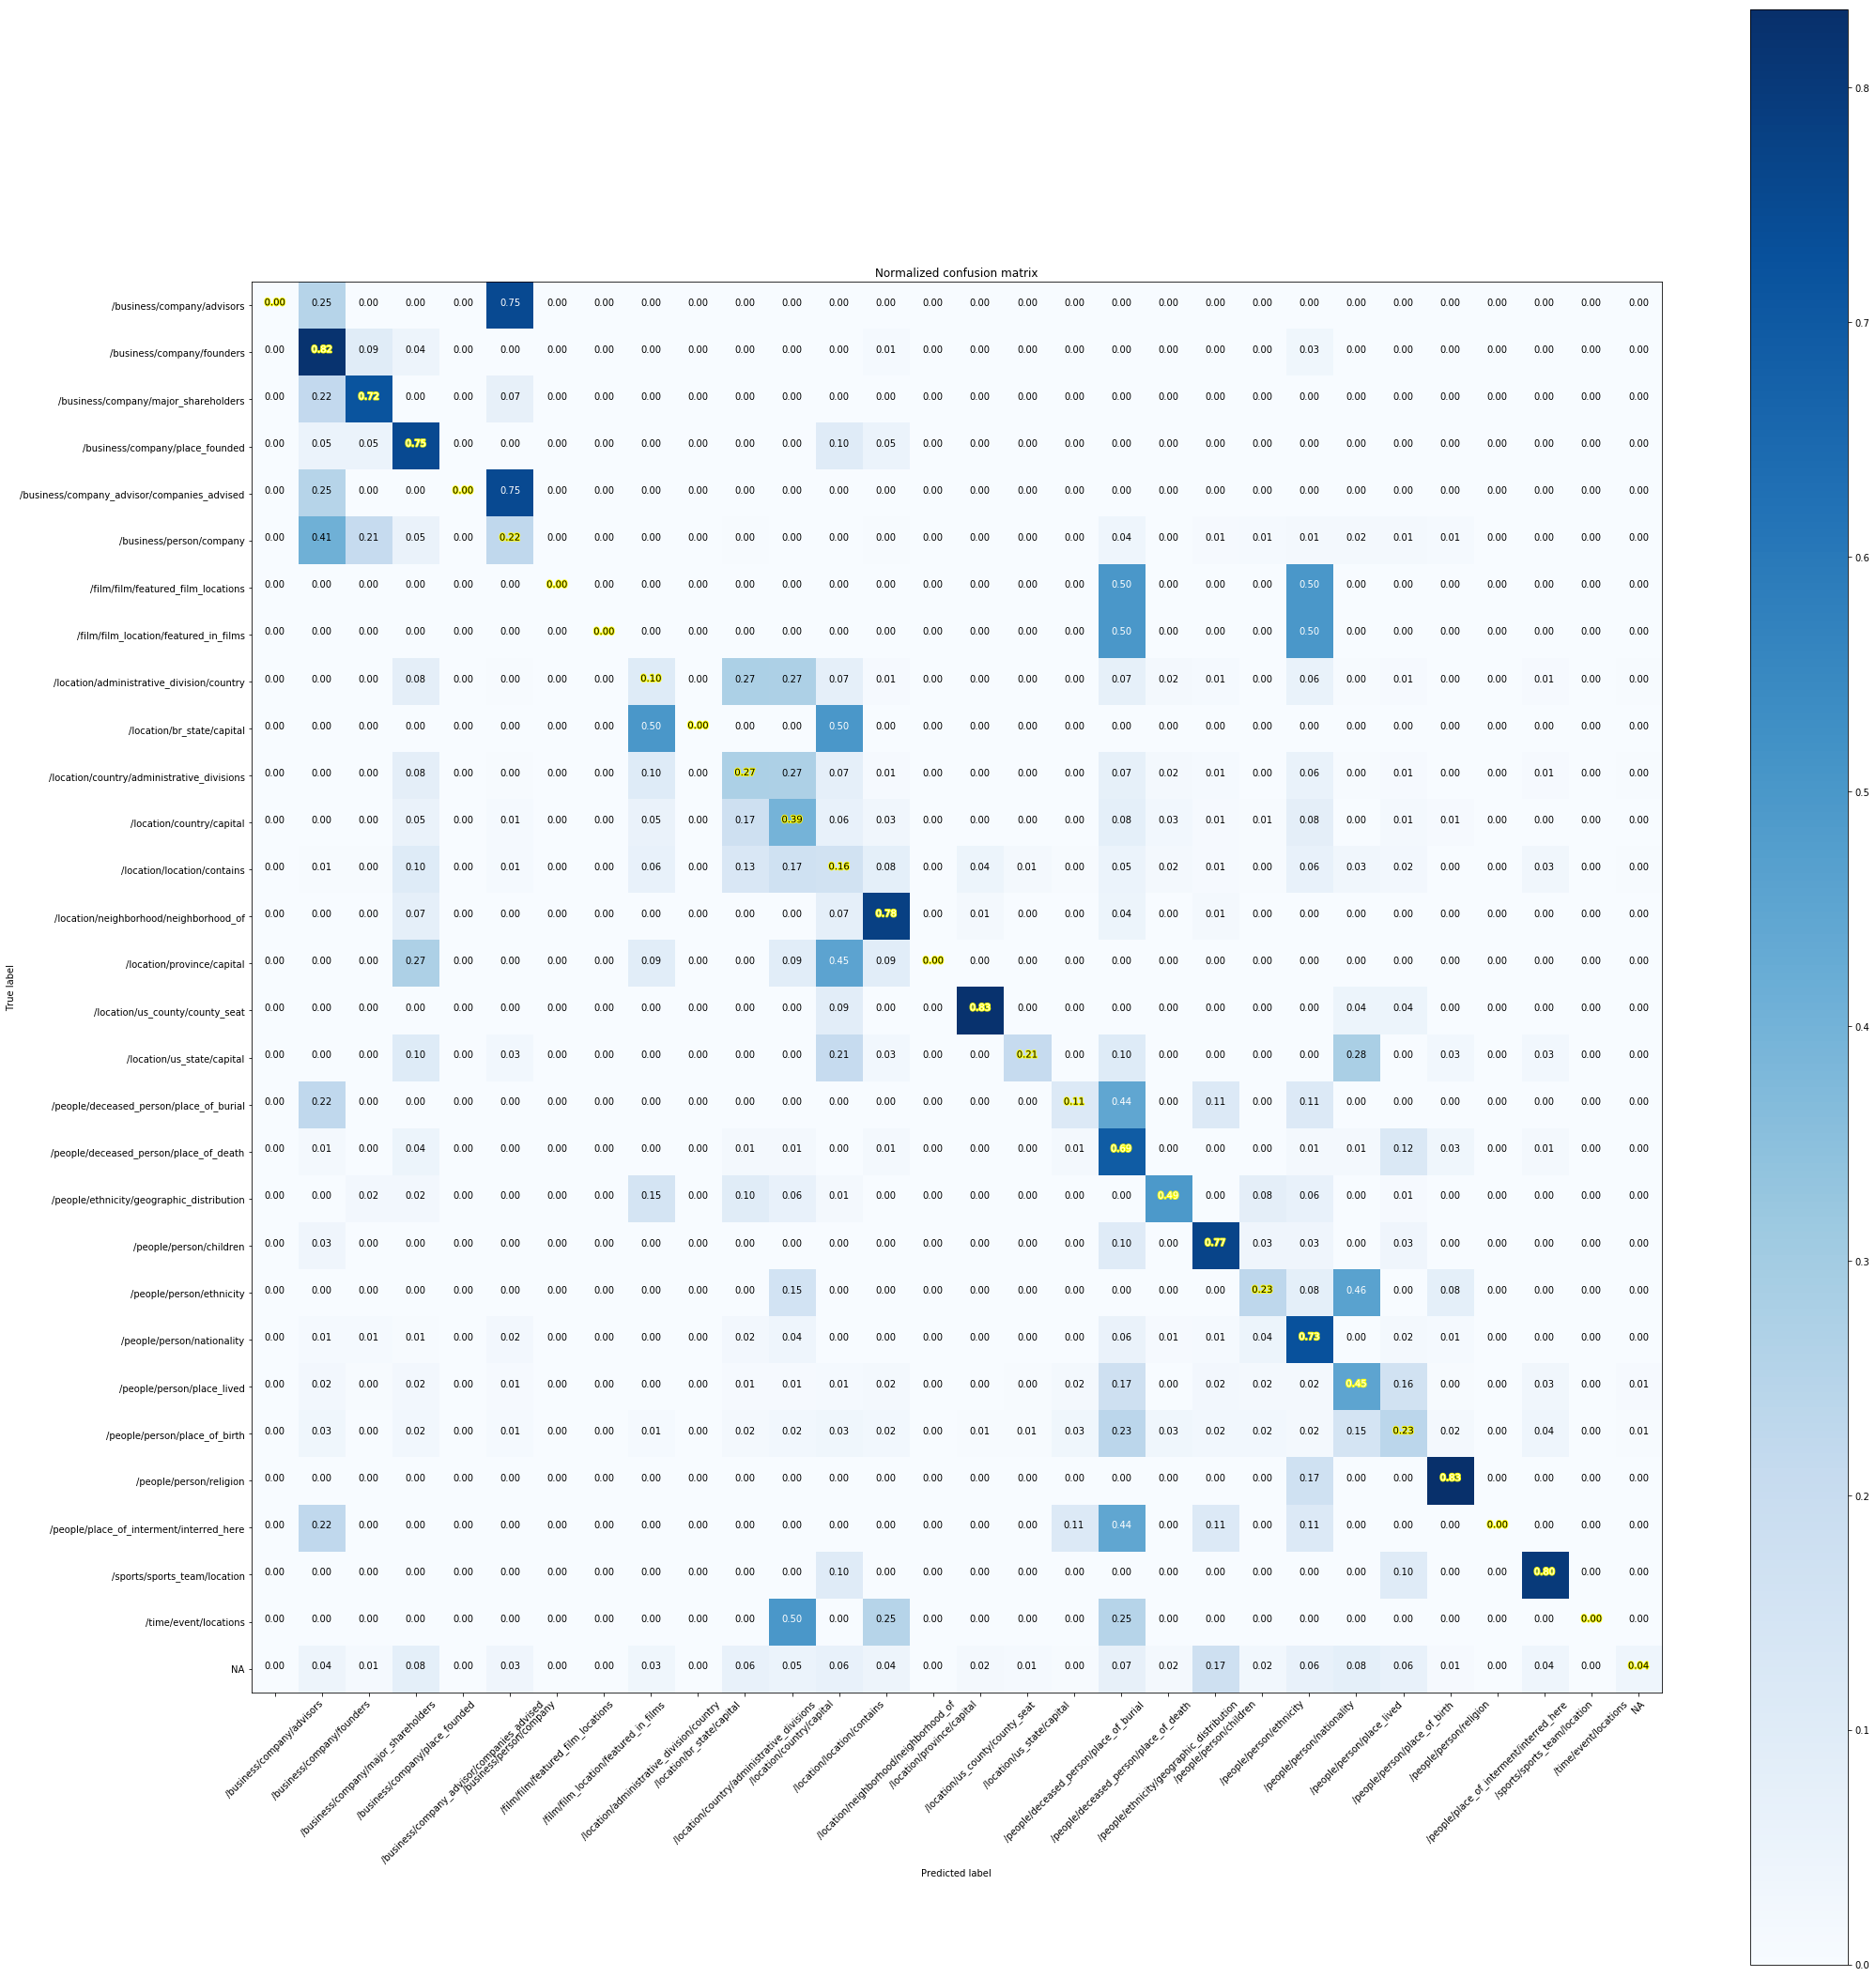

In [62]:
plt.rcParams["figure.figsize"] = (30, 30)

# Plot non-normalized confusion matrix
visualization.plot_confusion_matrix(cnf_matrix,
                      classes=classes,
                      title='Confusion matrix, without normalization').show()

# Plot normalized confusion matrix
visualization.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                      title='Normalized confusion matrix').show()

In [138]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13935034082298993415
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3997827162524441191
physical_device_desc: "device: XLA_CPU device"
]
